In [1]:
import os
import sys
import base64
import matplotlib.pyplot as plt
import numpy as np
from urllib import parse
import pandas as pd

current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, '..', '..')) 
if root_directory not in sys.path:
    sys.path.append(root_directory)

import logging
logging.basicConfig(level=logging.CRITICAL)

from code_utils.elastic import get_from_es, scroll_from_es

In [ ]:
body = {
  "size": 0,
  "track_total_hits": True,
    "aggs": {
        "type": {
        "terms": {
            "field": "type.keyword",
            "size": 10000000
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

In [ ]:
data

In [ ]:
labels = [x['key'] for x in data['aggregations']['type']['buckets']]
sizes = [int(x['doc_count']) for x in data['aggregations']['type']['buckets']]

plt.figure(figsize=(8,8), facecolor='white')
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.show()

In [ ]:
sum([int(x['doc_count']) for x in data['aggregations']['type']['buckets']])

In [ ]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
       "exists": {
         "field": "id"
       }
      }
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      },
      "aggs": {
        "type": {
          "terms": {
            "field": "type.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

In [ ]:
data

In [ ]:
data['aggregations']['predicted_labels']['buckets'][1]

In [ ]:
labels = ['journal-article','book','other','book-chapter','proceedings','thesis','preprint','HDR']
sizes = [x['doc_count']  for y in labels for x in data['aggregations']['predicted_labels']['buckets'][1]['type']['buckets'] if x['key']==y]
plt.figure(figsize=(8,8), facecolor='white')
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.show()

In [ ]:
#voir cb de % ipcc-like de scanR sont dans bso
#voir les grands thèmes associé aux ipcc-like dans le bso

In [44]:
df=pd.read_csv(root_directory+"\\bso-publications-latest.csv", sep=";")
counts = df['bso_classification'].value_counts()

C:\Users\haallat\AppData\Local\Temp\ipykernel_20016\1880636496.py:1: DtypeWarning: Columns (5,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(root_directory+"\\bso-publications-latest.csv", sep=";")


In [45]:
len(df)

3389746

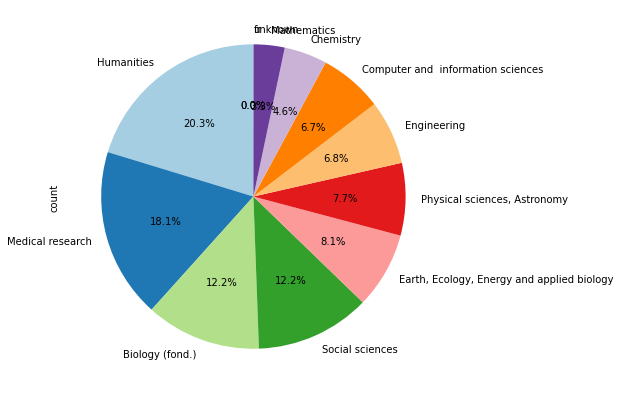

In [46]:
plt.figure(figsize=(7, 7), facecolor='white')
counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.show()

In [47]:
doi_bso=list(df.doi.drop_duplicates())

In [48]:
len(doi_bso)

2122162

In [51]:
id_bso=list(df.id.drop_duplicates())
len(id_bso)

3376364

In [32]:
body = {
  "size": 10000,  
  "track_total_hits": True,
  "_source": ["id"],  
  "query": {
    "term": {
      "predict_teds.label.keyword": "ipcc"  
    }
  }
}

data = get_from_es(body, 'scanr-publications', scroll=1)

In [33]:
len(data['hits']['hits'])

10000

In [34]:
ids = []

ids.extend([data['hits']['hits'][k]['_source']['id'] for k in range(len(data['hits']['hits']))])
scroll_id = data['_scroll_id']

while len(ids)!=(data['hits']['total']['value']):
    print(len(ids))
    scroll_data = scroll_from_es(scroll_id, scroll="1m")
    ids.extend([scroll_data['hits']['hits'][k]['_source']['id'] for k in range(len(scroll_data['hits']['hits']))])
    scroll_id = scroll_data['_scroll_id']

10000
20000
30000
40000
50000


In [35]:
len(ids)

53293

In [54]:
ids_in_bso=[x for x in id_bso if x in ids]

In [55]:
len(ids_in_bso)

46683

In [57]:
len(ids_in_bso)*100/len(ids)

87.59687013303811

In [63]:
df_ipcclike_bso=df[df.id.apply(lambda x: x in ids_in_bso)]

In [64]:
len(df_ipcclike_bso)

46688

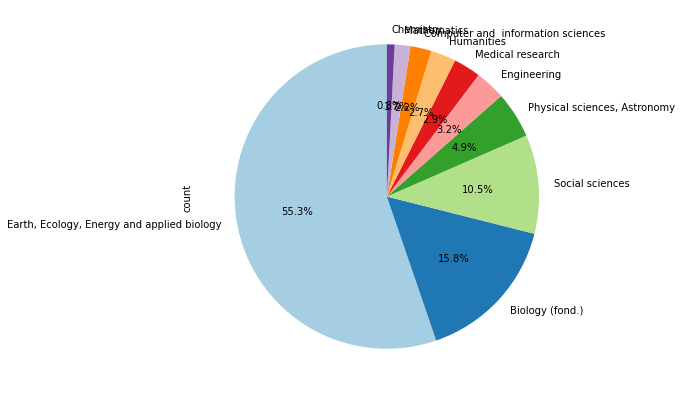

In [65]:
counts = df_ipcclike_bso['bso_classification'].value_counts()
plt.figure(figsize=(7, 7), facecolor='white')
counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.show()